# Introduction to JumpStart - Instance Segmentation

---
Welcome to Amazon [SageMaker JumpStart](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-jumpstart.html)! You can use JumpStart to solve many Machine Learning tasks through one-click in SageMaker Studio, or through [SageMaker JumpStart API](https://sagemaker.readthedocs.io/en/stable/doc_utils/jumpstart.html). In this demo notebook, we demonstrate how to use the JumpStart API for Instance Segmentation. Instance segmentation is the task of detecting and delineating each distinct object of interest appearing in an image. It is a fine-grained, pixel-level approach to developing computer vision applications. It tags every pixel in an image with a class label from a predefined set of classes. It differs from Semantic Segmentation in the following: Instance Segmentation treats multiple objects of the same class as distinct individual instances whereas Semantic Segmentation treats multiple objects of the same class as a single entity.


In this notebook, we demonstrate how to use pre-trained Instance Segmentation models for inference.

---

1. [Set Up](#1.-Set-Up)
2. [Select a pre-trained model](#2.-Select-a-pre-trained-model)
3. [Run inference on the pre-trained model](#3.-Run-inference-on-the-pre-trained-model)
    * [Retrieve JumpStart Artifacts & Deploy an Endpoint](#3.1.-Retrieve-JumpStart-Artifacts-&-Deploy-an-Endpoint)
    * [Download an example image for inference](#3.2.-Download-an-example-image-for-inference)
    * [Query endpoint and parse response](#3.3.-Query-endpoint-and-parse-response)
    * [Display model predictions](#3.4.-Display-model-predictions)
    * [Clean up the endpoint](#3.5.-Clean-up-the-endpoint)

Note: This notebook was tested on ml.t3.medium instance in Amazon SageMaker Studio with Python 3 (Data Science) kernel and in Amazon SageMaker Notebook instance with conda_python3 kernel.

## 1. Set Up

---
Before executing the notebook, there are some initial steps required for set up. This notebook requires latest version of sagemaker and ipywidgets

---

In [2]:
#!pip install sagemaker>=2.77.1 ipywidgets --upgrade --quiet

### Permissions and environment variables

---
To train and host on Amazon SageMaker, we need to set up and authenticate the use of AWS services. Here, we use the execution role associated with the current notebook as the AWS account role with SageMaker access. It has necessary permissions, including access to your data in S3. 

---

In [1]:
import sagemaker, boto3, json
from sagemaker import get_execution_role

#aws_role = get_execution_role()
aws_role = 'arn:aws:iam::976939723775:role/service-role/AmazonSageMaker-ExecutionRole-20210317T133000'
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

### 2. Select a pre-trained model

***
Here, we download jumpstart model_manifest file from the jumpstart s3 bucket, filter-out all the Instance Segmentation models and select a model for inference.
***

In [2]:
from ipywidgets import Dropdown

# download JumpStart model_manifest file.
boto3.client("s3").download_file(
    f"jumpstart-cache-prod-{aws_region}", "models_manifest.json", "models_manifest.json"
)
with open("models_manifest.json", "rb") as json_file:
    model_list = json.load(json_file)

# filter-out all the Instance Segmentation models from the manifest list.
is_models = []
for model in model_list:
    model_id = model["model_id"]
    if "-is-" in model_id and model_id not in is_models:
        is_models.append(model_id)

print(f"\033[38;5;2mChose a model for inference: \033[0;0m\n")

# display the model-ids in a dropdown to select a model for inference.
model_dropdown = Dropdown(
    options=is_models,
    value="mxnet-is-mask-rcnn-fpn-resnet101-v1d-coco",
    description="",
    style={"description_width": "initial"},
    layout={"width": "max-content"},
)
display(model_dropdown)

Chose a model for inference: 



Dropdown(layout=Layout(width='max-content'), options=('mxnet-is-mask-rcnn-fpn-resnet101-v1d-coco', 'mxnet-is-m…

In [3]:
# model_version="*" fetches the latest version of the model
model_id, model_version = model_dropdown.value, "*"

## 3. Run inference on the pre-trained model

***

Using JumpStart, we can perform inference on the pre-trained model, even without fine-tuning it first on a new dataset. 
***

### 3.1. Retrieve JumpStart Artifacts & Deploy an Endpoint

***
We retrieve the `deploy_image_uri`, `deploy_source_uri`, and `base_model_uri` for the pre-trained model. To host the pre-trained base-model, we create an instance of [`sagemaker.model.Model`](https://sagemaker.readthedocs.io/en/stable/api/inference/model.html) and deploy it.
***

In [7]:
from sagemaker import image_uris, model_uris, script_uris, hyperparameters
from sagemaker.model import Model
from sagemaker.predictor import Predictor
from sagemaker.utils import name_from_base


endpoint_name = name_from_base(f"jumpstart-example-infer-{model_id}")

inference_instance_type = "ml.p3.2xlarge"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,  # automatically inferred from model_id
    image_scope="inference",
    model_id=model_id,
    model_version=model_version,
    instance_type=inference_instance_type,
)

# Retrieve the inference script uri. This includes scripts for model loading, inference handling etc.
deploy_source_uri = script_uris.retrieve(
    model_id=model_id, model_version=model_version, script_scope="inference"
)


# Retrieve the base model uri
base_model_uri = model_uris.retrieve(
    model_id=model_id, model_version=model_version, model_scope="inference"
)


# Create the SageMaker model instance
model = Model(
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    model_data=base_model_uri,
    entry_point="inference.py",  # entry point file in source_dir and present in deploy_source_uri
    role=aws_role,
    predictor_cls=Predictor,
    name=endpoint_name,
)

# deploy the Model. Note that we need to pass Predictor class when we deploy model through Model class,
# for being able to run inference through the sagemaker API.
base_model_predictor = model.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    predictor_cls=Predictor,
    endpoint_name=endpoint_name,
)

-------!

### 3.2. Download an example image for inference
---
We download an example image from the JumpStart assets S3 bucket.

---

In [9]:
jumpstart_assets_s3_bucket = f"jumpstart-cache-prod-{aws_region}"
pedestrian_img_key_prefix = "inference-notebook-assets"
pedestrian_img = "img_pedestrian.png"

boto3.client("s3").download_file(
    jumpstart_assets_s3_bucket, f"{pedestrian_img_key_prefix}/{pedestrian_img}", pedestrian_img
)

### 3.3. Query endpoint and parse response

---
Input to the endpoint is a single image in binary format. Response of the endpoint is a set of bounding boxes, masks, class names and scores for the predictions. Endpoint also returns the image overlaid with the mask. JumpStart allows the flexibility in the number of predictions returned. Below, we show to predict two objects per image by appending `;n_predictions=2` to Accept. To predict xx boxes, one can change it to `;n_predictions=xx` or to get all the predicted boxes, one can remove `;n_predictions=2`. 

---

In [10]:
import json


def query(model_predictor, image_file_name):
    """Query the model predictor."""

    with open(image_file_name, "rb") as file:
        input_img_rb = file.read()

    query_response = model_predictor.predict(
        input_img_rb,
        {
            "ContentType": "application/x-image",
            "Accept": "application/json;verbose;n_predictions=2",
        },
    )
    return query_response


def parse_response(query_response):
    """Parse response and return a set of bounding boxes, masks, class names and scores for predictions along with the original image overlaid with the mask."""

    response_dict = json.loads(query_response)
    return (
        response_dict["ids"],
        response_dict["scores"],
        response_dict["bboxes"],
        response_dict["masks"],
        response_dict["labels"],
        response_dict["image_with_masks"],
    )

In [11]:
query_response = query(base_model_predictor, pedestrian_img)
ids, scores, bboxes, masks, labels, image_with_masks = parse_response(query_response)

### 3.4. Display model predictions
---
Next, we to plot the boxes on top of image with masks. For this, we adopt a similar function from [GluonCV](https://cv.gluon.ai/_modules/gluoncv/utils/viz/bbox.html#plot_bbox).

---

In [12]:
def plot_bbox(
    img,
    bboxes,
    scores=None,
    labels=None,
    thresh=0.5,
    class_names=None,
    colors=None,
    ax=None,
    linewidth=3.5,
    fontsize=12,
):
    """Plot box over the predicted objects."""

    from matplotlib import pyplot as plt
    import random

    img = img.copy()
    ax.imshow(img.astype(np.uint8))

    colors = dict()

    for i, bbox in enumerate(bboxes):
        if scores.flat[i] < thresh or labels.flat[i] < 0:
            continue
        cls_id = int(labels.flat[i]) if labels is not None else -1
        if cls_id not in colors:
            if class_names is not None:
                colors[cls_id] = plt.get_cmap("hsv")(cls_id / len(class_names))
            else:
                colors[cls_id] = (random.random(), random.random(), random.random())
        xmin, ymin, xmax, ymax = [int(x) for x in bbox]
        rect = plt.Rectangle(
            (xmin, ymin),
            xmax - xmin,
            ymax - ymin,
            fill=False,
            edgecolor=colors[cls_id],
            linewidth=linewidth,
        )
        ax.add_patch(rect)
        if class_names is not None and cls_id < len(class_names):
            class_name = class_names[cls_id]
        else:
            class_name = str(cls_id) if cls_id >= 0 else ""
        score = "{:.3f}".format(scores.flat[i]) if scores is not None else ""
        if class_name or score:
            ax.text(
                xmin,
                ymin - 2,
                "{:s} {:s}".format(class_name, score),
                bbox=dict(facecolor=colors[cls_id], alpha=0.5),
                fontsize=fontsize,
                color="white",
            )
    return ax

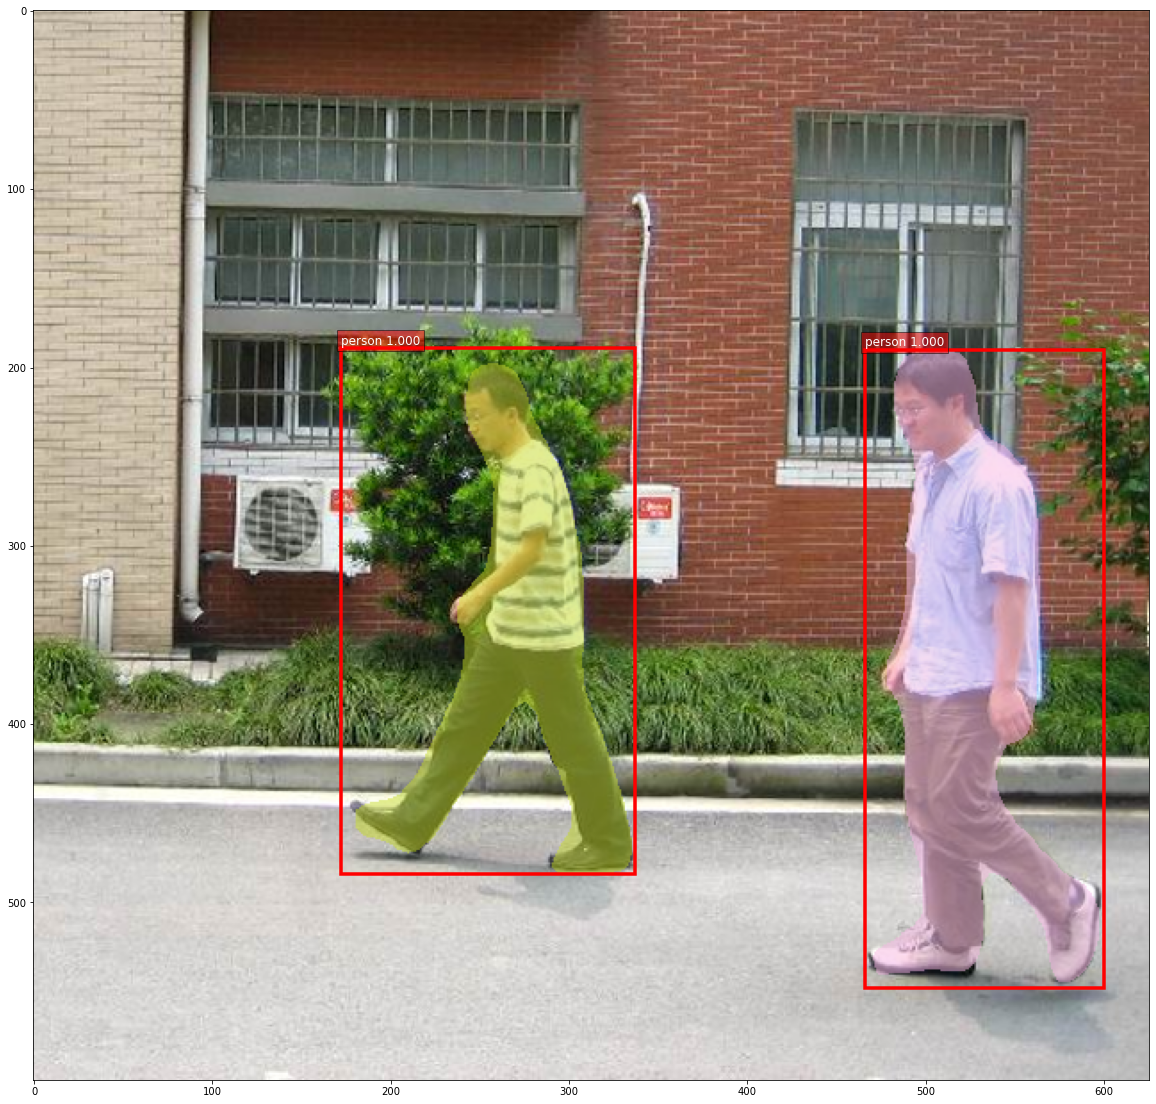

In [13]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np

ids, scores, bboxes, masks, image_with_masks = (
    np.array(ids),
    np.array(scores),
    np.array(bboxes),
    np.array(masks),
    np.array(image_with_masks),
)
width, height = image_with_masks.shape[1], image_with_masks.shape[0]

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1)
ax = plot_bbox(image_with_masks, bboxes, scores, ids, class_names=labels, ax=ax)
plt.show()

### 3.5. Clean up the endpoint

In [ ]:
# Delete the SageMaker endpoint
base_model_predictor.delete_model()
base_model_predictor.delete_endpoint()